In [49]:
from temgymbasic.model import (
    Model,
)
from temgymbasic import components as comp
from temgymbasic.utils import calculate_wavelength, calculate_phi_0
import matplotlib.pyplot as plt
import numpy as np

%matplotlib widget

In [50]:
n_rays = 10000

phi_0 = 200e3
wavelength = calculate_wavelength(phi_0)
k = 2 * np.pi / wavelength
wavelengths = np.full(n_rays, wavelength)

size = 100
det_shape = (size, size)
pixel_size = 1e-6
dsize = det_shape[0] * pixel_size

x_det = np.linspace(-dsize / 2, dsize / 2, size)
scale = 1e-4
sample_dist = 0.5
condenser_dist = 0.1    
objective_dist = sample_dist + 1e-2
total_dist = 1

x_width = 1 * scale
y_width = 1 * scale
centre_yx = (0, 0)
thickness = 50e-8

rotation = np.array([135, 0, 0])
# convergence_angle = 3e-3  #  milirads
#condenser_dist * np.tan(convergence_angle)

defocus = 1e-4

In [51]:


beam_radius = scale / 5

# Parameters for the lattice of gratings
line_width = 0.01 * scale  # Thickness of each grating line
grating_period = 0.05 * scale  # Spacing between gratings

grid_size = 100
x = np.linspace(-x_width / 2, x_width / 2, grid_size)
y = np.linspace(-y_width / 2, y_width / 2, grid_size)
z = np.linspace(0, thickness, 10)

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

# Create the lattice pattern
grating_X = (np.mod(X + grating_period / 2, grating_period) < line_width)
grating_Y = (np.mod(Y + grating_period / 2, grating_period) < line_width)
attenuation = np.where(grating_X | grating_Y, 1e11, 0)

# plt.figure()
# plt.imshow(attenuation[:, :, 0], extent=(x[0], x[-1], y[0], y[-1]))

In [52]:

components = (
    comp.GaussBeam(
        z=0.0,
        voltage=200e3,
        radius=beam_radius,
        amplitude=1.0,
        wo=1e-10
    ),
    # comp.Lens(
    #     z=condenser_dist,
    #     m=-1e-11,
    #     f=sample_dist - condenser_dist - defocus,
    #     name='Condenser Lens',
    # ),
    comp.AttenuatingSample(
        z=sample_dist,
        x_width=x_width,
        y_width=y_width,
        thickness=thickness,
        rotation=rotation,
        attenuation=attenuation,
        centre_yx=centre_yx,
    ),
    # comp.Lens(
    #     z=objective_dist,
    #     z1=sample_dist - objective_dist,
    #     z2=total_dist - objective_dist,
    #     name='Objective Lens',
    # ),
    comp.AccumulatingDetector(
        z=total_dist,
        pixel_size=pixel_size,
        shape=det_shape,
        buffer_length=1,
        interference='ray'
    ),
)


model = Model(components, backend='cpu')

sample_detector_model = comp.Detector(z=1.0,
                                      pixel_size=pixel_size, 
                                      shape=det_shape,
                                      interference='ray')


rays_before_sample = model.run_to_z(z=sample_dist, num_rays=n_rays)
rays_after_sample = model.run_to_z(z=sample_dist+thickness*2, num_rays=n_rays)

print(np.average(rays_before_sample.amplitude))
print(np.average(rays_after_sample.amplitude))

all_rays = tuple(model.run_iter(num_rays=n_rays, random=False))
rays_at_start = all_rays[0]
rays_at_end = all_rays[-1]


image_before_sample = sample_detector_model.get_image(rays_before_sample)
image_after_sample = sample_detector_model.get_image(rays_after_sample)
image_at_end = model.detector.get_image(rays_at_end)


1.0
0.6108411488526686


[[-1.99983462e-05  1.99999037e-05]
 [-1.99983462e-05  1.99999037e-05]
 [-1.99983462e-05  1.99999037e-05]]
[0.        0.5000005 1.       ]


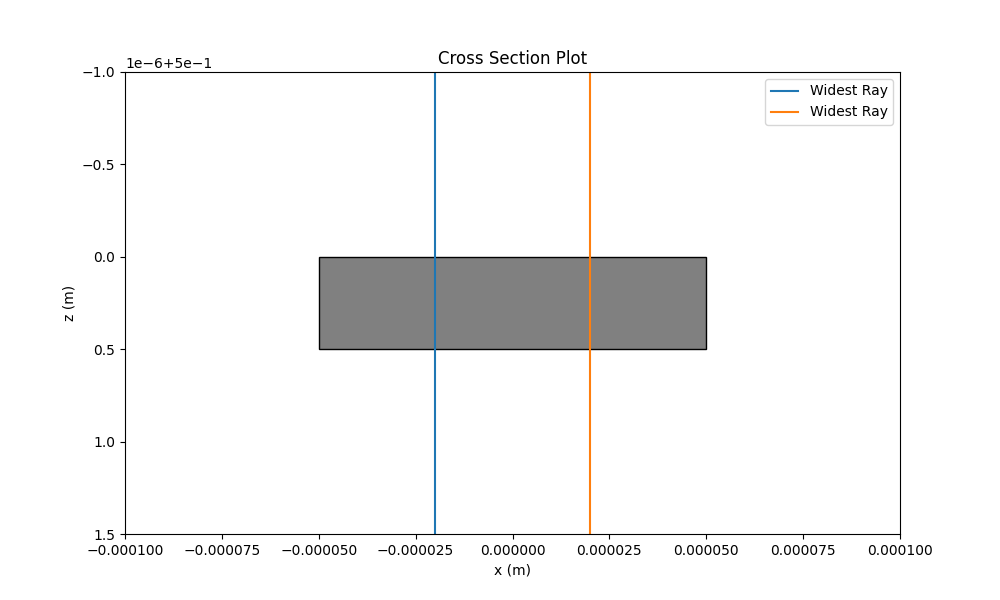

In [53]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the attenuating sample as a filled rectangle
sample_y = centre_yx[0] + np.array([-y_width / 2, y_width / 2, y_width / 2, -y_width / 2, -y_width / 2])
sample_z = [sample_dist, sample_dist, sample_dist + thickness, sample_dist + thickness, sample_dist]
ax.fill(sample_y, sample_z, 'gray', edgecolor='black')

xvals = np.stack(tuple(r.x_central for r in all_rays), axis=0)
zvals = np.asarray(tuple(r.z for r in all_rays))

widest_ray_xvals = xvals[:, [np.argmin(xvals), np.argmax(xvals)]]
print(widest_ray_xvals)
print(zvals)

ax.plot(widest_ray_xvals, zvals, label='Widest Ray')

ax.set_xlim(-y_width, y_width)
ax.set_ylim(sample_dist - 1e-6, sample_dist + thickness + 1e-6)
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_title('Cross Section Plot')
ax.legend()
# Plot the convergence angle as an arc
ax.invert_yaxis()

plt.show()

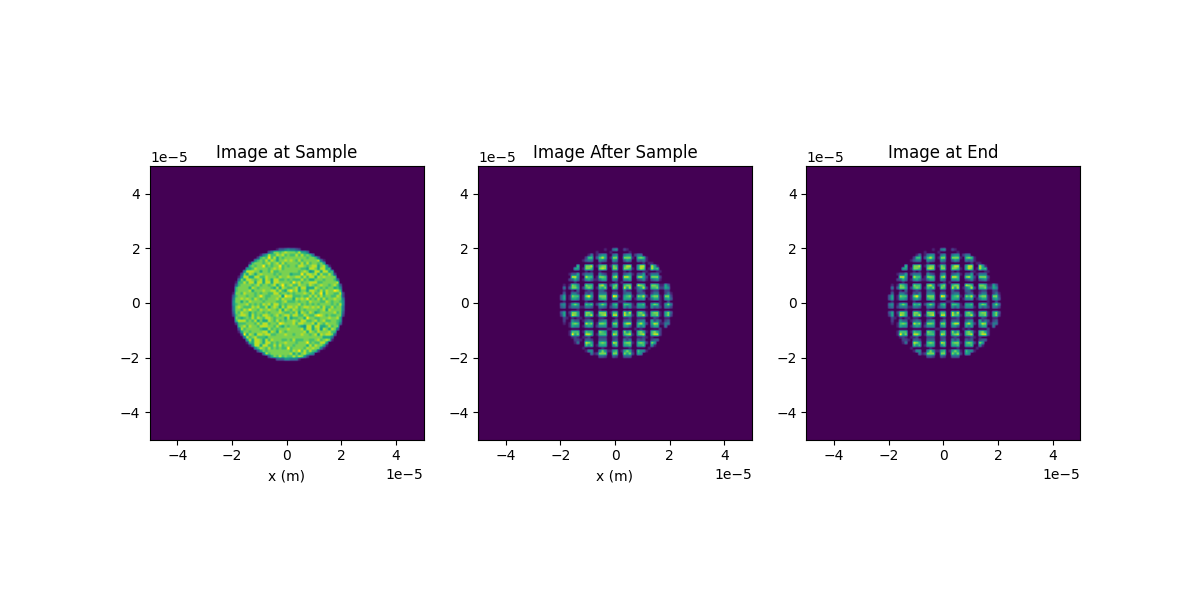

In [54]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].imshow(np.abs(image_before_sample), extent=sample_detector_model.extent)
# axs[0].plot(rays_before_sample.x_central, rays_before_sample.y_central, 'r.', markersize=1)
axs[0].set_xlabel('x (m)')
axs[0].set_title('Image at Sample')

axs[1].imshow(np.abs(image_after_sample), extent=sample_detector_model.extent)
# axs[1].plot(rays_after_sample.x_central, rays_after_sample.y_central, 'r.', markersize=1)
axs[1].set_xlabel('x (m)')
axs[1].set_title('Image After Sample')

axs[2].imshow(np.abs(image_at_end), extent=model.detector.extent)
axs[2].set_title('Image at End')

plt.show()